# Lemon Classifier Using ML frameworks in python

### Objectives:
* import the training dataset
* preprocess the training data
* train the model using ML framework
* validate / testing accuracy
* export model for microservice deployment
* have fun and enjoy a refeshing slice of lemon py :D
# 🍋

#### ========== Elliott M. Lynch 2/8/21 ==========

## framework selection considerations
in the contemporary context of ML frameworks in 2021, pytorch appears to be highly regarded,
for the purposes of this explorative notebook, demonstrating a binary image classifer in torch would be a suitable choice for this project's framework

In [157]:
# include module dependencies
import os
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
import numpy as np
import pandas as pd
from PIL import Image
from matplotlib import image
from matplotlib import pyplot
import cv2
from skimage.color import rgb2gray
from skimage import io
from IPython.display import display # to display images in ipython notebook

### import lemon dataset
* the training data was curated from duckduckgo image searches 

In [2]:
# working with directories 

dir_name = "unprocessed-training/"
root = [dir_name + root for root in os.listdir(dir_name)]

""" training_set[0][:] contains positive examples & training_set[1][:] 
contains negative examples """
dataset_dir = [[],[]] 

index = -1
for branch in root:
    index += 1
    sub_dir = (os.listdir(branch))
    for img in sub_dir:
        dataset_dir[index].append(branch + "/" + img)
print(dataset_dir[1][1])


unprocessed-training/negative/download - 2020-07-27T235330.775.png


In [3]:
# converting directory to image set 
dataset_pos = [image.imread(img, 0) for img in dataset_dir[0]]
dataset_neg = [image.imread(img, 0) for img in dataset_dir[1]]


### testing our array training set to make sure it has been properly converted

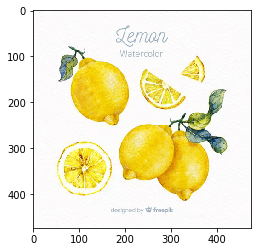

In [4]:
# display the array of pixels as an image
example = dataset_pos[0]
pyplot.imshow(example)
pyplot.show()


### experiment with manipulating an image
* funky lemons

(195, 180, 3)


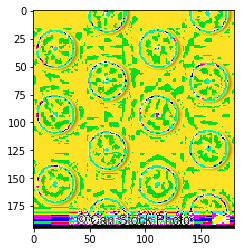

In [5]:
x = dataset_pos[1] + 1
y = np.array([[1, 2, 3], [4, 3, 2]])
print(x.shape) # print the dimension of the image
pyplot.imshow(x)
pyplot.show()

### array clip 
* clip the value of an array between a given range

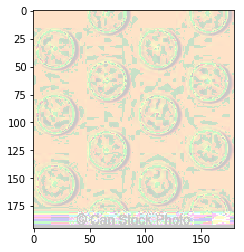

In [6]:
x1 = np.clip(x, 200, 255)
pyplot.imshow(x1)
pyplot.show()

### preprocess training data
* resize 
* greyscale
* denoise?

### Resize images

In [8]:
image_dim = 40
dataset_pos = [cv2.resize(img, dsize=(image_dim, image_dim), interpolation=cv2.INTER_CUBIC) 
                for img in dataset_pos]
dataset_neg = [cv2.resize(img, dsize=(image_dim, image_dim), interpolation=cv2.INTER_CUBIC) 
                for img in dataset_neg]

print(dataset_neg[5].shape)

(40, 40, 3)


### convert to greyscale

In [9]:
dataset_pos = [rgb2gray(img) for img in dataset_pos]
dataset_neg = [rgb2gray(img) for img in dataset_neg]

### denoise

In [10]:
# TODO:

### display a preprocessed image

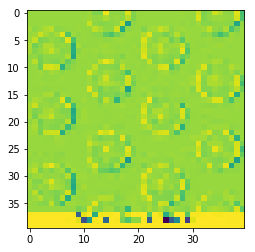

In [11]:
preprocessed_example = dataset_pos[1]
pyplot.imshow(preprocessed_example)
pyplot.show()

### unify preprocessed data set

In [12]:
X = np.array((dataset_pos + dataset_neg)) 
print(X[1].shape)

(40, 40)


### labling the dataset

In [14]:
pos_count = len(dataset_pos)
neg_count = len(dataset_neg)
pos = np.ones((pos_count, 1))
neg = np.zeros((neg_count, 1))
Y = np.vstack((pos, neg)) # combine the arrays to create a single lable vector
np.shape(Y)
print("The class for the example @ pos 222 is ", Y[222])
print(Y[222] == 1)

The class for the example @ pos 222 is  [1.]
[ True]


### useful variables

In [15]:
m = Y.size # number of examples in training set
n = image_dim ** 2 # number of features for each training examnple

### convert our data into feature vector representation
* we must represent the training example of the feature vector of the 40 x 40 pixel images (1600 features)

In [16]:
X_vec = np.array([x.reshape(1, n) for x in X]) # reshape each example
X_vec.shape = (m, n) # reshape to array from tensor
print(X_vec.shape)

(992, 1600)


### reconstructing vectorized data
* we can reshape the feature vector to reconstruct the image after using x.reshape(image_dim, image_dim)

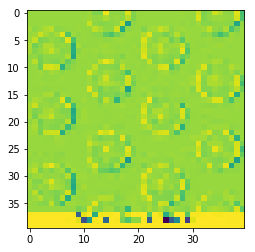

In [17]:
q = X_vec[1]
pyplot.imshow(q.reshape(image_dim, image_dim)) # reshape the feature vector back to the image
pyplot.show()

### joining labels with data 
* this part could use some work:
I need to figure out how to shuffle the data before the split 

In [18]:
X_labled = np.hstack((X_vec, Y)) # it is important to note 
#the lable has been added as a feature for the purposes of shuffling the data

### shuffling the data

In [23]:
np.random.shuffle(X_labled)

### seperating shuffled examples and labels 

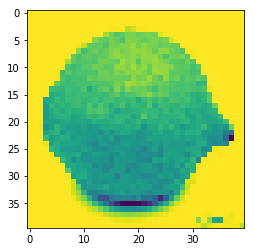

In [101]:
X_vec = X_labled[:, :-1]
Y = X_labled[:, -1] 
test_img = X_vec[1]
pyplot.imshow(test_img.reshape(image_dim, image_dim)) # reshape the feature vector back to the image
pyplot.show()

### splitting the data train / validation / test and respective labels
* adhearing to the 60/20/20 split

In [111]:
X_train = X_vec[0: int(m * 0.6)]
Y_train = Y[0: int(m * 0.6)]
X_val = X_vec[int(m * 0.6): int(m * 0.8)]
Y_val = Y[int(m * 0.6): int(m * 0.8)]
X_test = X_vec[int(m * 0.8)::]
Y_test = Y[int(m * 0.8)::]
print(X_val[-1] == X_test[0])

[False False False ... False False False]


### sanity check time, lets make sure the split is mutually exclusive

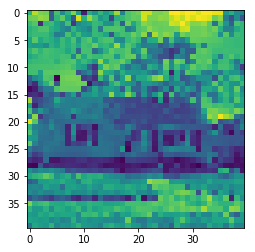

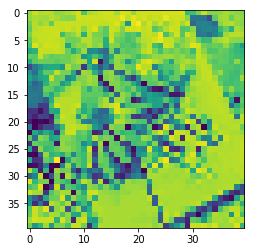

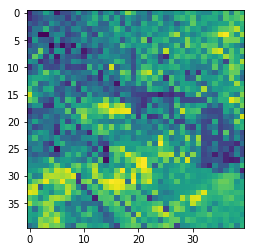

In [112]:
test0 = X_train[0].reshape(image_dim, image_dim)
test1 = X_val[-1].reshape(image_dim, image_dim)
test2 = X_test[0].reshape(image_dim, image_dim)
pyplot.imshow(test0)
pyplot.show()
pyplot.imshow(test1)
pyplot.show()
pyplot.imshow(test2)
pyplot.show()
x1 = [1, 2 ,3, 4]

## wait a minute, theres a better way?
* data input using torch dataloader

In [175]:
# defining a class for lemon data which extends 
# the torch Dataset class

class LemonData(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        image = io.imread(img_path)
        y_label = torch.tensor(int(self.annotations.iloc[index, 1]))
        
        if self.transform:
            image = self.transform(image)

### the dataset object

In [176]:
# config transform
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5,0.5))])
# load data      
dataset = LemonData(csv_file = "LemonData.csv", root_dir = "LemonData/", transform = transform)

print(dataset[0])

train_set, test_set = torch.utils.data.random_split(dataset,[(m - 1) * 0.8,(m - 1) * 0.2])
train_loader = torch.utils.data.DataLoader()

None


ValueError: Sum of input lengths does not equal the length of the input dataset!

#### following along the pytorch documentation of data
* trainloader

In [181]:
trainloader = torch.utils.data.DataLoader(train_set, batch_size = 4, shuffle = False, num_workers = 2)
testloader = torch.utils.data.DataLoader(test_set, batch_size = 4, shuffle = False, num_workers = 2)

classes = ("Not Lemon", "Lemon")

NameError: name 'train_set' is not defined

### Defining a convolutional Neural Network Architecture (ConVNet)

In [178]:
# 'boiler plate'
import torch.nn as nn
import torch.nn.functional as F

# neural network defined for one channel image 
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__() # static/super
        self.conv1 = nn.Conv2d(3, 6, 5) # define a layer
        self.pool = nn.MaxPool2d(2,2) # pooling
        self.cov2 = nn.Conv2d(6, 16, 5) # 
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def  forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F,relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
        
net = Net()
    
        

### Define a Lose function and optimizer

In [179]:
import torch.optim as optim 

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(),
                      lr = 0.001, momentum = 0.9) # learning rate

### train the network

In [180]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs = data
        labels = Y_train
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

RuntimeError: Expected 4-dimensional input for 4-dimensional weight [6, 3, 5, 5], but got 2-dimensional input of size [4, 1600] instead

## validation / performance testing

## results 

### testing PIL images

In [ ]:
im = Image.open(training_set[0][1])
im_rot = im.rotate(45)
display(im_rot)

## exporting the model

## ML as a microservice through restful API's on the cloud

## Conclusion 
* thank you :D